In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from matplotlib import style 
# style.use('seaborn-colorblind')
sns.set(style='white')

In [3]:
import sys
sys.path.append('../')


from scripts.util import cleanAxes

In [4]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [5]:
from statannotations.Annotator import Annotator

- https://github.com/trevismd/statannotations 


## CRISPRi-screen
<!-- Aim: analyzing differential phenotype of CRISPRi-screen data

Tool: [ScreenProcessing](https://github.com/mhorlbeck/ScreenProcessing)

#### Result:
`CRISPRi-screen/hl60_exp1/DAC_processing_output_genetable_collapsed.txt`
<!--`CRISPRi-screen/hl60_exp2/DAC_processing_output_genetable_collapsed.txt`-->

<!-- > __Note__: all 5 gRNAs considered here.  
-->

#### `DESeq2` normalization 
- https://physiology.med.cornell.edu/faculty/skrabanek/lab/angsd/lecture_notes/08_practical.pdf

In [ ]:
library(DESeq2)
library(dplyr)

In [3]:
data = read.table(
    'CRISPRi-screen/hl60_exp1/DAC_mergedcountstable.txt',
    sep='\t',header=TRUE,row.names=1)[-c(1,2),]

data <- mutate_all(data, function(x) as.numeric(as.character(x)))

meta = data.frame(
    sampletype=c(rep('T0',2),rep('treated',2),rep('untreated',2)),
    row.names=colnames(data)
)

In [4]:
dds <- DESeqDataSetFromMatrix(countData = data, colData = meta, design = ~ sampletype)
dds <- estimateSizeFactors(dds)
normalized_counts <- counts(dds, normalized=TRUE)
# DESeq.rlog <- rlog(dds, blind = TRUE)
# rlog.norm.counts <- assay(DESeq.rlog)

write.table(
    normalized_counts, 
    # rlog.norm.counts,
    file="CRISPRi-screen/hl60_exp1/DAC_mergedcountstable_normalized_counts.txt", sep="\t", quote=F
)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


#### Barplot
<!-- 
> Hani - Feb 2022
> - try Welch’s t-test
> - can you show non-targeting guides as well? -->

In [749]:
# Ci_counts0 = pd.read_csv('CRISPRi-screen/hl60_exp1/DAC_mergedcountstable.txt',sep='\t',index_col=0).iloc[2:,]
# Ci_counts0.index = Ci_counts0.index.str.split('_').str[0]
# Ci_counts0.index.name = None
# Ci_counts0 = Ci_counts0.astype(int)
# Ci_counts0 = Ci_counts0[Ci_counts0.sum(axis=1) > 5]

In [40]:
Ci_counts = pd.read_csv('../CRISPRi-screen/hl60_exp1/DAC_mergedcountstable_normalized_counts.txt',sep='\t')
Ci_counts.describe().iloc[:3,]

,T0,T0.1,treated,treated.1,untreated,untreated.1
count,104535.00000,104535.00000,104535.000000,104535.000000,104535.000000,104535.000000
mean,545.70697,545.70697,727.478423,727.544124,590.554094,588.936462
std,345.09397,345.09397,2496.508008,2549.954165,478.568782,476.587327


In [41]:
Ci_counts.index = Ci_counts.index.str.split('_').str[0]
Ci_counts.index.name = None
# Ci_counts = Ci_counts[Ci_counts.sum(axis=1) > 5]
# Ci_counts = Ci_counts[np.sum(Ci_counts == 0,axis=1) == 0]

In [10]:
# Ci_counts[Ci_counts.index != 'non-targeting'].describe().iloc[:3,]
# Ci_counts[Ci_counts.index == 'non-targeting'].describe().iloc[:3,]

In [11]:
def plot_Ci_counts(counts,sgrna,top_n=3, ax=None,ylim=None,T0=True,annotate=True):
    
    df = counts[counts.index == sgrna].T
    if top_n:
        # select top n sgRNAs
        df = pd.DataFrame(
            [list(df.iloc[row,:].nlargest(top_n)) for row,_ in enumerate(df.index)],
            index=[row_id for _,row_id in enumerate(df.index)],
            columns=[sgrna for i in range(top_n)]
        )
        
    df['treatment'] = ["T0","T0","Decitabine","Decitabine","DMSO","DMSO"]
    # df_column_uniquify
    df_columns = df.columns
    new_columns = []
    for counter,item in enumerate(df_columns):
        if sgrna in item:
            newitem = "{}_gRNA{}".format(item, counter + 1)
        else:
            newitem = item
        new_columns.append(newitem)
    df.columns = new_columns
    
    dd=pd.melt(
        df,
        id_vars='treatment',value_vars=[col for col in df.columns if sgrna in col],var_name='columns'
    )
    data_title = "gRNA count" # Normalized
    dd = dd.rename({'value':data_title},axis=1)
    dd[data_title] = dd[data_title].astype(int)
    my_pal = {"Decitabine": "c", "DMSO": "lightgray", 'T0':'azure'}
    
    if not T0:
        dd = dd[dd.treatment != 'T0'].sort_values(by='treatment', axis=0, ascending=True)
    if ax:
        cleanAxes(ax)
        p = sns.boxplot(x='treatment',y=data_title,data=dd,hue='treatment',palette=my_pal,ax=ax,linewidth=0.5,showfliers=False)
        
        pairs=[("Decitabine","DMSO")]

        if annotate:
            annotator = Annotator(ax, pairs, x='treatment',y=data_title,data=dd)
            # Welch’s t-test
            annotator.configure(
                test='t-test_welch', text_format='simple', loc='outside',
                show_test_name=False,verbose=False,fontsize=8,line_width=1#,color='blue'
            )
            annotator.apply_and_annotate()
            
        ax.set_title(sgrna,y=1.1,fontsize=10)
        ax.set_xlabel(None)
        ax.set_ylim(top=ylim)
        ax.set_yscale('log')

        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')
            
        # return p
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.tick_params(axis='both', which='minor', labelsize=8)

    else: 
        return dd

No handles with labels found to put in legend.


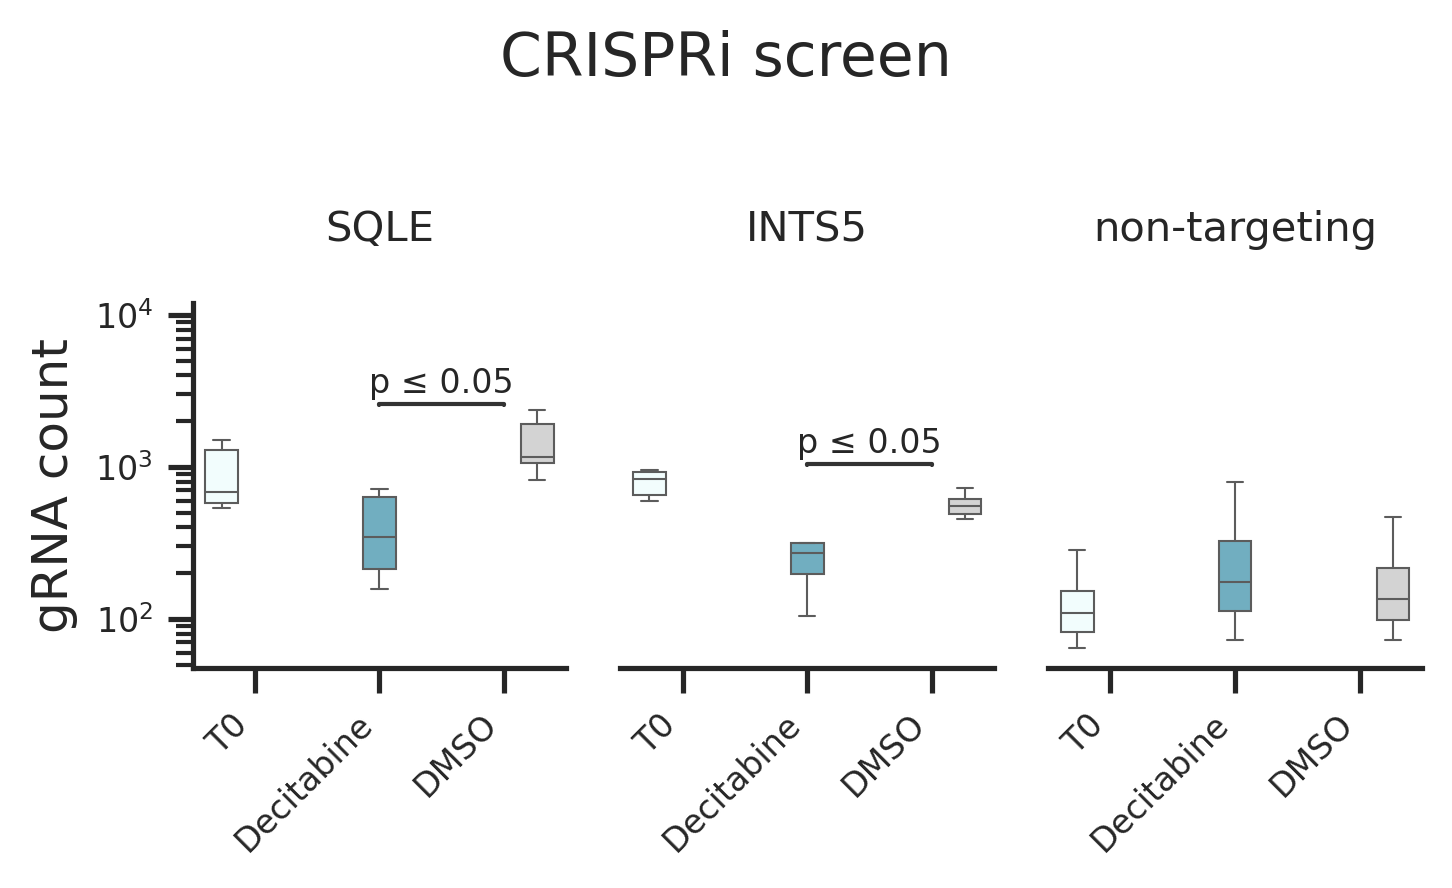

In [12]:
f, axes = plt.subplots(1, 3,figsize=(5,3),dpi=300)
leg = plt.legend()
ylim=1.2*10**4

plot_Ci_counts(Ci_counts,sgrna = 'SQLE',ax=axes[0],T0=True,ylim=ylim)
plot_Ci_counts(Ci_counts,sgrna = 'INTS5',ax=axes[1],T0=True,ylim=ylim)
plot_Ci_counts(Ci_counts,sgrna = 'non-targeting',top_n=800,ax=axes[2],T0=True,ylim=ylim,annotate=False)

for ax in axes:
    ax.get_legend().remove()
    
cleanAxes(axes[1],left=False)
cleanAxes(axes[2],left=False)
axes[1].set_ylabel(None)
axes[2].set_ylabel(None)
axes[1].tick_params(axis='y',label1On=False)
axes[2].tick_params(axis='y',label1On=False)
# axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 6})

f.suptitle('CRISPRi screen')
f.tight_layout()
f.savefig('Target-genes/Ci_counts.pdf')

No handles with labels found to put in legend.


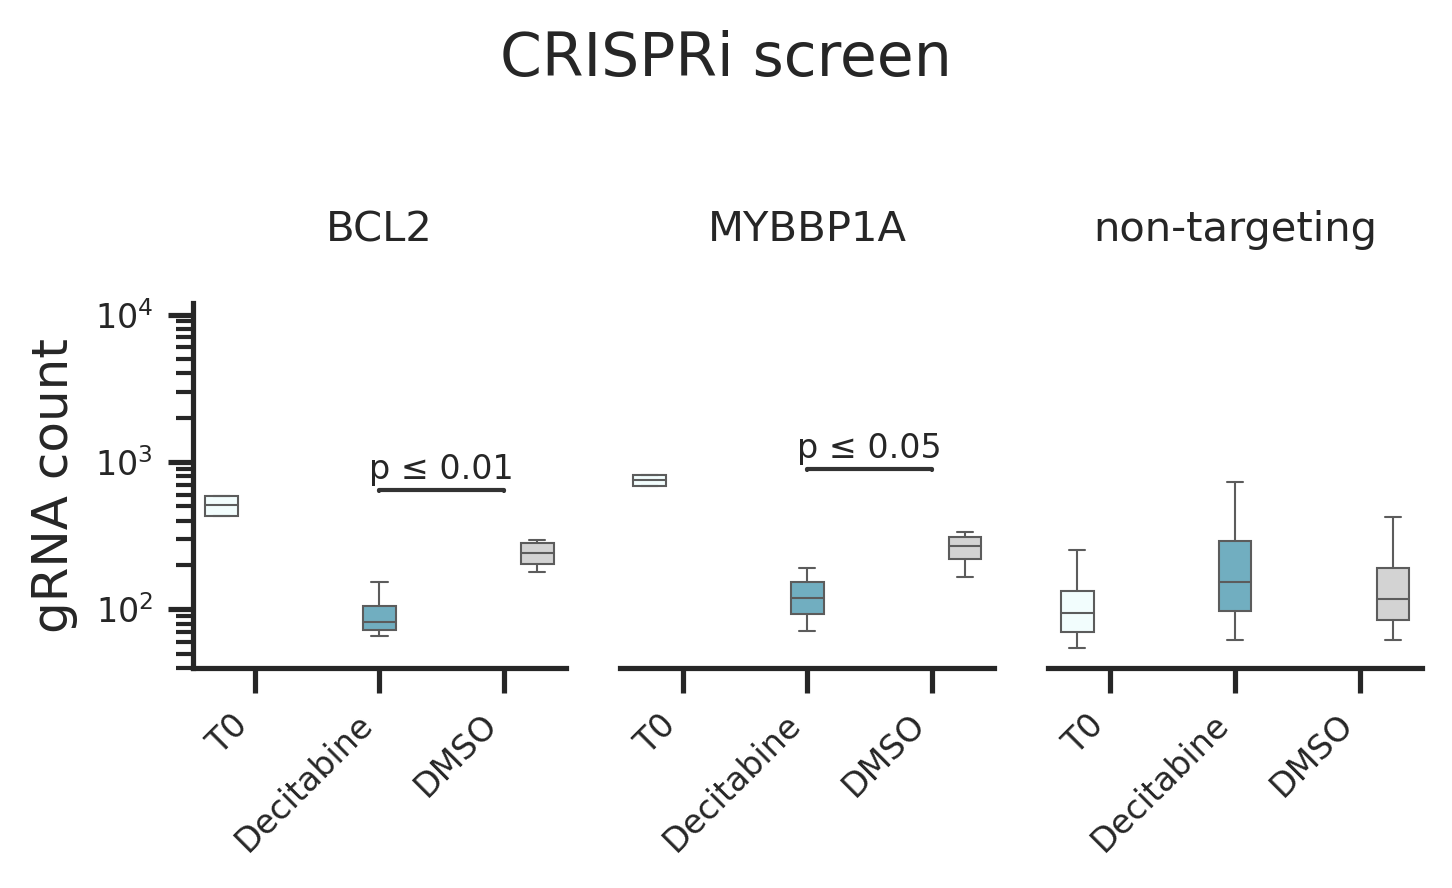

In [13]:
f, axes = plt.subplots(1, 3,figsize=(5,3),dpi=300)
leg = plt.legend()
ylim=1.2*10**4

plot_Ci_counts(Ci_counts,top_n=2, sgrna = 'BCL2',ax=axes[0],T0=True,ylim=ylim)
plot_Ci_counts(Ci_counts,top_n=2,sgrna = 'MYBBP1A',ax=axes[1],T0=True,ylim=ylim)
plot_Ci_counts(Ci_counts,sgrna = 'non-targeting',top_n=800,ax=axes[2],T0=True,ylim=ylim,annotate=False)

for ax in axes:
    ax.get_legend().remove()
    
cleanAxes(axes[1],left=False)
cleanAxes(axes[2],left=False)
axes[1].set_ylabel(None)
axes[2].set_ylabel(None)
axes[1].tick_params(axis='y',label1On=False)
axes[2].tick_params(axis='y',label1On=False)
# axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 6})

f.suptitle('CRISPRi screen')
f.tight_layout()
f.savefig('Target-genes/Ci_counts_2.pdf')

In [46]:
# Ci_counts[Ci_counts.index.isin(['MAT2A','MAT1A','MAT2B'])]

No handles with labels found to put in legend.


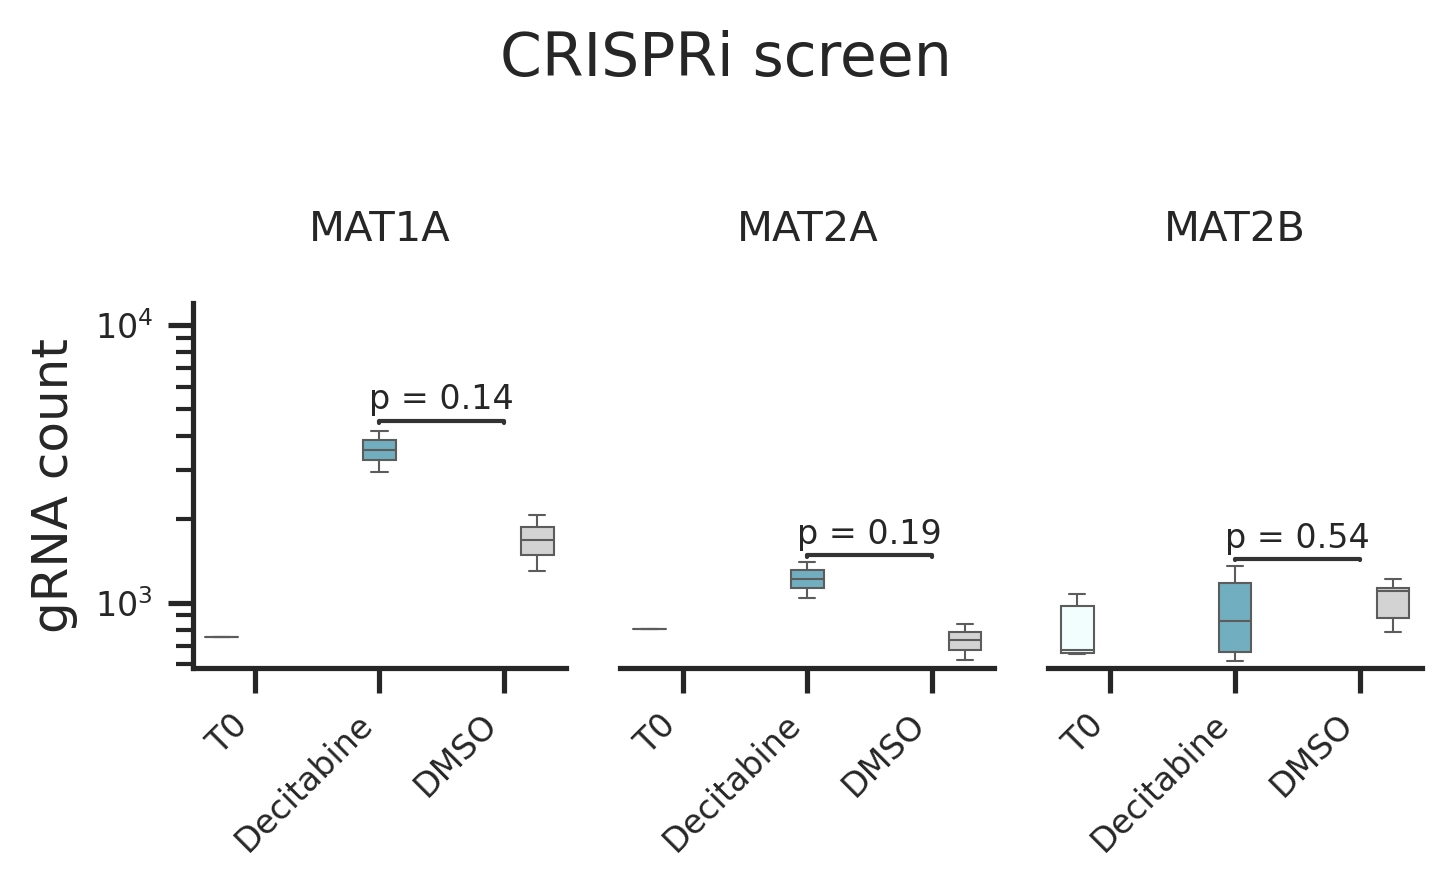

In [156]:
f, axes = plt.subplots(1, 3,figsize=(5,3),dpi=300)
leg = plt.legend()
ylim=1.2*10**4

plot_Ci_counts(Ci_counts,sgrna = 'MAT1A', ax=axes[0],top_n=1,T0=True,ylim=ylim)
plot_Ci_counts(Ci_counts,sgrna = 'MAT2A',ax=axes[1],top_n=1,T0=True,ylim=ylim)
plot_Ci_counts(Ci_counts,sgrna = 'MAT2B', ax=axes[2],top_n=3,T0=True,ylim=ylim)

for ax in axes:
    ax.get_legend().remove()
    
cleanAxes(axes[1],left=False)
cleanAxes(axes[2],left=False)
axes[1].set_ylabel(None)
axes[2].set_ylabel(None)
axes[1].tick_params(axis='y',label1On=False)
axes[2].tick_params(axis='y',label1On=False)
# axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 6})

f.suptitle('CRISPRi screen')
f.tight_layout()
# f.savefig('Target-genes/Ci_counts_2.pdf')

In [517]:
# f, axes = plt.subplots(1, 2,figsize=(6,3))

# plot_Ci_counts(Ci_counts,gene = 'BCL2',ax=axes[0])
# plot_Ci_counts(Ci_counts,gene = 'FDFT1',ax=axes[1])

# for ax in axes:
#     leg = plt.legend()
#     ax.get_legend().remove()
# # axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plt.tight_layout()

## RNA-seq


In [7]:
exp = pd.read_csv('../RNA-seq/exp/delta_exp_table.txt',sep='\t')

In [8]:
exp.set_index('gene_name').loc[['SQLE','INTS5','BCL2','MYBBP1A'],:].filter(regex='hl60')#.filter(regex='h_pvalue')

,hl60_6h_log2FC,hl60_6h_pvalue,hl60_72h_log2FC,hl60_72h_pvalue,hl60_72h_only_log2FC,hl60_72h_only_pvalue,hl60_120h_log2FC,hl60_120h_pvalue
gene_name,,,,,,,,
SQLE,0.113950,2.305181e-11,-0.525967,2.305181e-11,-0.576365,0.087040,-0.754409,2.305181e-11
INTS5,0.192253,2.918347e-02,-0.861624,2.918347e-02,-0.911393,0.052916,-0.495722,2.918347e-02
BCL2,-0.194502,9.235412e-02,0.046305,9.235412e-02,-0.002800,0.995018,-0.906291,9.235412e-02
MYBBP1A,-0.321097,1.220844e-15,-0.594186,1.220844e-15,-0.644625,0.063032,-1.566491,1.220844e-15


### Expression

In [9]:
exp_counts  = pd.read_csv('../RNA-seq/exp/deseq2_norm.txt',sep='\t')

In [24]:
# def convert_pvalue_to_asterisks(pvalue):
#     if pvalue <= 0.0001:
#         return "****"
#     elif pvalue <= 0.001:
#         return "***"
#     elif pvalue <= 0.01:
#         return "**"
#     elif pvalue <= 0.05:
#         return "*"
#     return ""

def plot_time_rna_seq(counts,gene,ax,data,pvalue,plot='boxplot',ymin=None,ylim=None):
    
    df = counts[counts['name'] == gene].set_index('name').T
    df['treatment'] = df.index.str.split('_').str[-2]
    df['line'] = df.index.str.split('_').str[0]
    df['time'] = 72
    df.loc[df.line == 'hl60','time'] = df[df.line == 'hl60'].index.str.split('_').str[1].str[:-1].astype(int)
    dd=pd.melt(
        df[df.line == 'hl60'],
        id_vars=['treatment','time'],value_vars=[gene],var_name='columns'
    ).sort_values(by='time', axis=0, ascending=True)
    dd['treatment'] = dd['treatment'].str.replace('t', 'Decitabine')
    dd['treatment'] = dd['treatment'].str.replace('u', 'DMSO')
    dd = dd.sort_values(by='treatment', axis=0, ascending=True).rename({'value':f'{data}'},axis=1)

    my_pal = {"Decitabine": "c", "DMSO": "lightgray"}
    
    cleanAxes(ax)
    if plot == 'pointplot':
        p = sns.pointplot(x='time',y=f'{data}',data=dd,hue='treatment',palette=my_pal,ax=ax)
        
        # perform two-way ANOVA
        # model = ols(f'{data} ~ treatment + time + treatment:time', data=dd).fit()
        # pvalue = sm.stats.anova_lm(model, typ=2).iloc[0,3]
        # pvalue_str = '{:.2e}'.format(pvalue)

        # star = convert_pvalue_to_asterisks(pvalue)
        # add pvalue as text
        ax.text(0.8, 1,
                # ,
                # f'P={pvalue_str}',
                'P={:.2e}'.format(pvalue),
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=8,
                # color='darkblue',
                weight="bold",
                transform = ax.transAxes
               )
        ax.set_title(gene,y=1.15,fontsize=12)
    
    # ax.set_ylim([ymin,ylim])
    # ax.set_yscale('log')
    if plot == 'boxplot':
        p = sns.boxplot(x='time',y=f'{data}',data=dd,hue='treatment',palette=my_pal,ax=ax)
    
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=8)

    return p

In [25]:
exp.set_index('gene_name').loc[['SQLE','INTS5'],:].filter(regex='hl60')#.filter(regex='h_pvalue')

,hl60_6h_log2FC,hl60_6h_pvalue,hl60_72h_log2FC,hl60_72h_pvalue,hl60_72h_only_log2FC,hl60_72h_only_pvalue,hl60_120h_log2FC,hl60_120h_pvalue
gene_name,,,,,,,,
SQLE,0.113950,2.305181e-11,-0.525967,2.305181e-11,-0.576365,0.087040,-0.754409,2.305181e-11
INTS5,0.192253,2.918347e-02,-0.861624,2.918347e-02,-0.911393,0.052916,-0.495722,2.918347e-02


In [26]:
sqle_pvalue  = exp.set_index('gene_name').loc['SQLE','hl60_72h_pvalue']
ints5_pvalue = exp.set_index('gene_name').loc['INTS5','hl60_72h_pvalue']

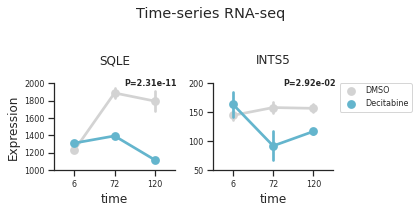

In [27]:
f, axes = plt.subplots(1, 2,figsize=(6,3))

plot_time_rna_seq(exp_counts,gene = 'SQLE',ax=axes[0],data='Expression',pvalue = sqle_pvalue, plot='pointplot')
axes[0].get_legend().remove()
axes[0].set_ylim(bottom=1000,top=2000)
# axes[0].set_yscale('log')

plot_time_rna_seq(exp_counts,gene = 'INTS5',ax=axes[1],data='Expression',pvalue = ints5_pvalue,plot='pointplot')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 8})
axes[1].set_ylabel(None)
axes[1].set_ylim(bottom=50,top=200)

f.suptitle('Time-series RNA-seq')
f.tight_layout()
f.savefig('Target-genes/Exp.pdf')

In [28]:
bcl2_pvalue  = exp.set_index('gene_name').loc['BCL2','hl60_72h_pvalue']
mybbp1a_pvalue  = exp.set_index('gene_name').loc['MYBBP1A','hl60_72h_pvalue']

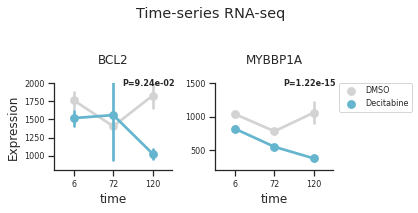

In [63]:
f, axes = plt.subplots(1, 2,figsize=(6,3))

plot_time_rna_seq(exp_counts,gene = 'BCL2',ax=axes[0],data='Expression',pvalue = bcl2_pvalue, plot='pointplot')
axes[0].get_legend().remove()
axes[0].set_ylim(bottom=800,top=2000)
# axes[0].set_yscale('log')

plot_time_rna_seq(exp_counts,gene = 'MYBBP1A',ax=axes[1],data='Expression',pvalue = mybbp1a_pvalue,plot='pointplot')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 8})
axes[1].set_ylabel(None)
axes[1].set_ylim(bottom=200,top=1500)

f.suptitle('Time-series RNA-seq')
f.tight_layout()
f.savefig('Target-genes/Exp_2.pdf')

#### Down, 120h | GOBP_REGULATION_OF_CHOLESTEROL_BIOSYNTHETIC_PROCESS

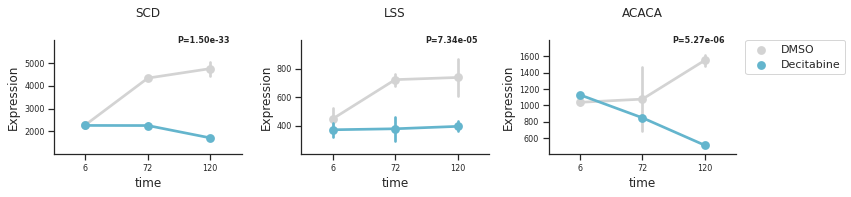

In [60]:
f, axes = plt.subplots(1, 3,figsize=(12,3))

plot_time_rna_seq(
    exp_counts,gene = 'SCD',ax=axes[0],data='Expression',
    pvalue=exp.set_index('gene_name').loc['SCD','hl60_72h_pvalue'],
    plot='pointplot'
)
axes[0].get_legend().remove()
axes[0].set_ylim(bottom=1001,top=5999)
# axes[0].set_yscale('log')

plot_time_rna_seq(
    exp_counts,gene = 'LSS',ax=axes[1],data='Expression',
    pvalue=exp.set_index('gene_name').loc['LSS','hl60_72h_pvalue'],
    plot='pointplot')
axes[1].get_legend().remove()
axes[1].set_ylim(bottom=201,top=999)

plot_time_rna_seq(
    exp_counts,gene = 'ACACA',ax=axes[2],data='Expression',
    pvalue=exp.set_index('gene_name').loc['ACACA','hl60_72h_pvalue'],
    plot='pointplot')
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[2].set_ylim(bottom=401,top=1799)

plt.tight_layout()
plt.savefig('Target-genes/Exp_3.pdf')

> #### SCD, stearoyl CoA desaturase
> [__Metabolic adaptation of acute lymphoblastic leukemia to the central nervous system microenvironment is dependent on Stearoyl CoA desaturase__](https://pubmed.ncbi.nlm.nih.gov/33479702/)
> - _We identified a metabolic signature of fatty-acid synthesis in CNS leukemia, highlighting Stearoyl-CoA desaturase (SCD1) as a key player. In vivo SCD1 overexpression increases CNS disease, whilst genetic or pharmacological inhibition of SCD1 decreases CNS load._

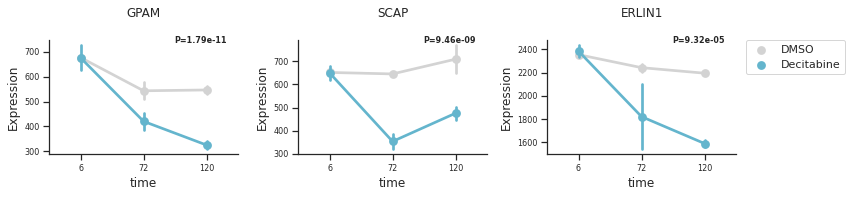

In [61]:
# gs = 'GOBP_REGULATION_OF_CHOLESTEROL_BIOSYNTHETIC_PROCESS'
# ['CYP51A1', 'FDFT1', 'SQLE', 'ERLIN1', 'KPNB1', 
# 'SC5D', 'HMGCR', 'SCAP', 'GPAM', 

f, axes = plt.subplots(1, 3,figsize=(12,3))

plot_time_rna_seq(
    exp_counts,gene = 'GPAM',ax=axes[0],data='Expression',
    pvalue=exp.set_index('gene_name').loc['GPAM','hl60_72h_pvalue'],
    plot='pointplot')
axes[0].get_legend().remove()
# axes[0].set_ylim(bottom=1000,top=2000)
# axes[0].set_yscale('log')

plot_time_rna_seq(
    exp_counts,gene = 'SCAP',ax=axes[1],data='Expression',
    pvalue=exp.set_index('gene_name').loc['SCAP','hl60_72h_pvalue'],
    plot='pointplot')
axes[1].get_legend().remove()
# axes[1].set_ylim(bottom=50,top=200)

plot_time_rna_seq(
    exp_counts,gene = 'ERLIN1',ax=axes[2],data='Expression',
    pvalue=exp.set_index('gene_name').loc['ERLIN1','hl60_72h_pvalue'],
    plot='pointplot')
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# axes[2].set_ylim(bottom=50,top=200)

plt.tight_layout()
# plt.savefig('Target-genes/Exp.pdf')

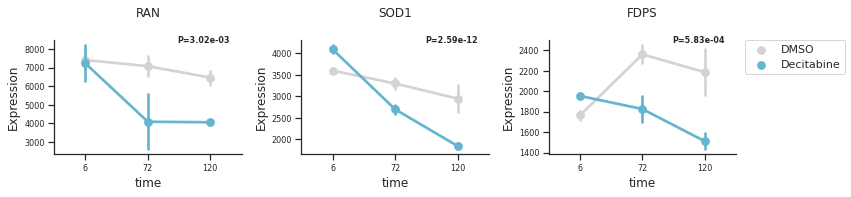

In [62]:
# 'RAN', 'SOD1', 'FDPS', 'PMVK', 'DHCR7']]

f, axes = plt.subplots(1, 3,figsize=(12,3))

plot_time_rna_seq(
    exp_counts,gene = 'RAN',ax=axes[0],data='Expression',
    pvalue=exp.set_index('gene_name').loc['RAN','hl60_72h_pvalue'],
    plot='pointplot')
axes[0].get_legend().remove()
# axes[0].set_ylim(bottom=1000,top=2000)
# axes[0].set_yscale('log')

plot_time_rna_seq(
    exp_counts,gene = 'SOD1',ax=axes[1],data='Expression',
    pvalue=exp.set_index('gene_name').loc['SOD1','hl60_72h_pvalue'],
    plot='pointplot')
axes[1].get_legend().remove()
# axes[1].set_ylim(bottom=50,top=200)

plot_time_rna_seq(
    exp_counts,gene = 'FDPS',ax=axes[2],data='Expression',
    pvalue=exp.set_index('gene_name').loc['FDPS','hl60_72h_pvalue'],
    plot='pointplot')
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# axes[2].set_ylim(bottom=50,top=200)

plt.tight_layout()
# plt.savefig('Target-genes/Exp.pdf')

In [64]:
# # 'RAN', 'SOD1', 'FDPS', 'PMVK', 'DHCR7']]

# f, axes = plt.subplots(1, 3,figsize=(12,3))

# plot_time_rna_seq(exp_counts,gene = 'FDFT1',ax=axes[0],data='Expression',plot='pointplot')
# axes[0].get_legend().remove()
# # axes[0].set_ylim(bottom=1000,top=2000)
# # axes[0].set_yscale('log')

# plot_time_rna_seq(exp_counts,gene = 'PMVK',ax=axes[1],data='Expression',plot='pointplot')
# axes[1].get_legend().remove()

# plot_time_rna_seq(exp_counts,gene = 'DHCR7',ax=axes[2],data='Expression',plot='pointplot')
# axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# # axes[1].set_ylim(bottom=50,top=200)

# plt.tight_layout()
# # plt.savefig('Target-genes/Exp.pdf')

    GOMF_S_ADENOSYLMETHIONINE_DEPENDENT_METHYLTRANSFERASE_ACTIVITY

    [['METTL1', 'FTSJ1', 'PRMT5', 'SETD6', 'FBL', 'DPH5', 'KMT2A', 'EEF2KMT', 'METTL8', 'PRMT1', 'METTL16', 'COQ3', 'PRMT7', 'PEMT', 'MEN1', 'CARM1', 'SETD7', 'TFB2M', 'TRMT61A', 'SETMAR', 'TRMT61B', 'MRM3', 'TRMT10C', 'PRMT3', 'WDR5'], ['TFB1M', 'NSUN2', 'TARBP1', 'TRMT11', 'BUD23', 'DIMT1', 'METTL2A', 'TRMT6', 'RNMT', 'SUV39H1', 'TRMT1', 'FTSJ3', 'NOP2', 'ICMT', 'NSUN4', 'MRM2', 'EEF1AKMT3', 'EMG1', 'TRMT5', 'DNMT1', 'RRP8', 'SETDB2', 'THUMPD2', 'METTL5', 'PRDM16', 'EEF1AKMT1', 'SUV39H2', 'SETD9', 'CARNMT1', 'WDR4', 'COMTD1', 'ZCCHC4', 'PRMT6', 'EHMT2', 'MRM1', 'EEF1AKMT4']]


In [126]:
pvalue_120h = 'P(120h) = {:.2e}'.format(
    exp.set_index('gene_name').loc['MAT2A','hl60_120h_pvalue']
)
pvalue_72h = 'P(72h) = {:.2e}'.format(
    exp.set_index('gene_name').loc['MAT2A','hl60_72h_pvalue']
)

pvalue_6h = 'P(6h) = {:.2e}'.format(
    exp.set_index('gene_name').loc['MAT2A','hl60_6h_pvalue']
)

In [130]:
pvalue_str = f'{pvalue_120h}'#\n{pvalue_72h}\n{pvalue_6h}'

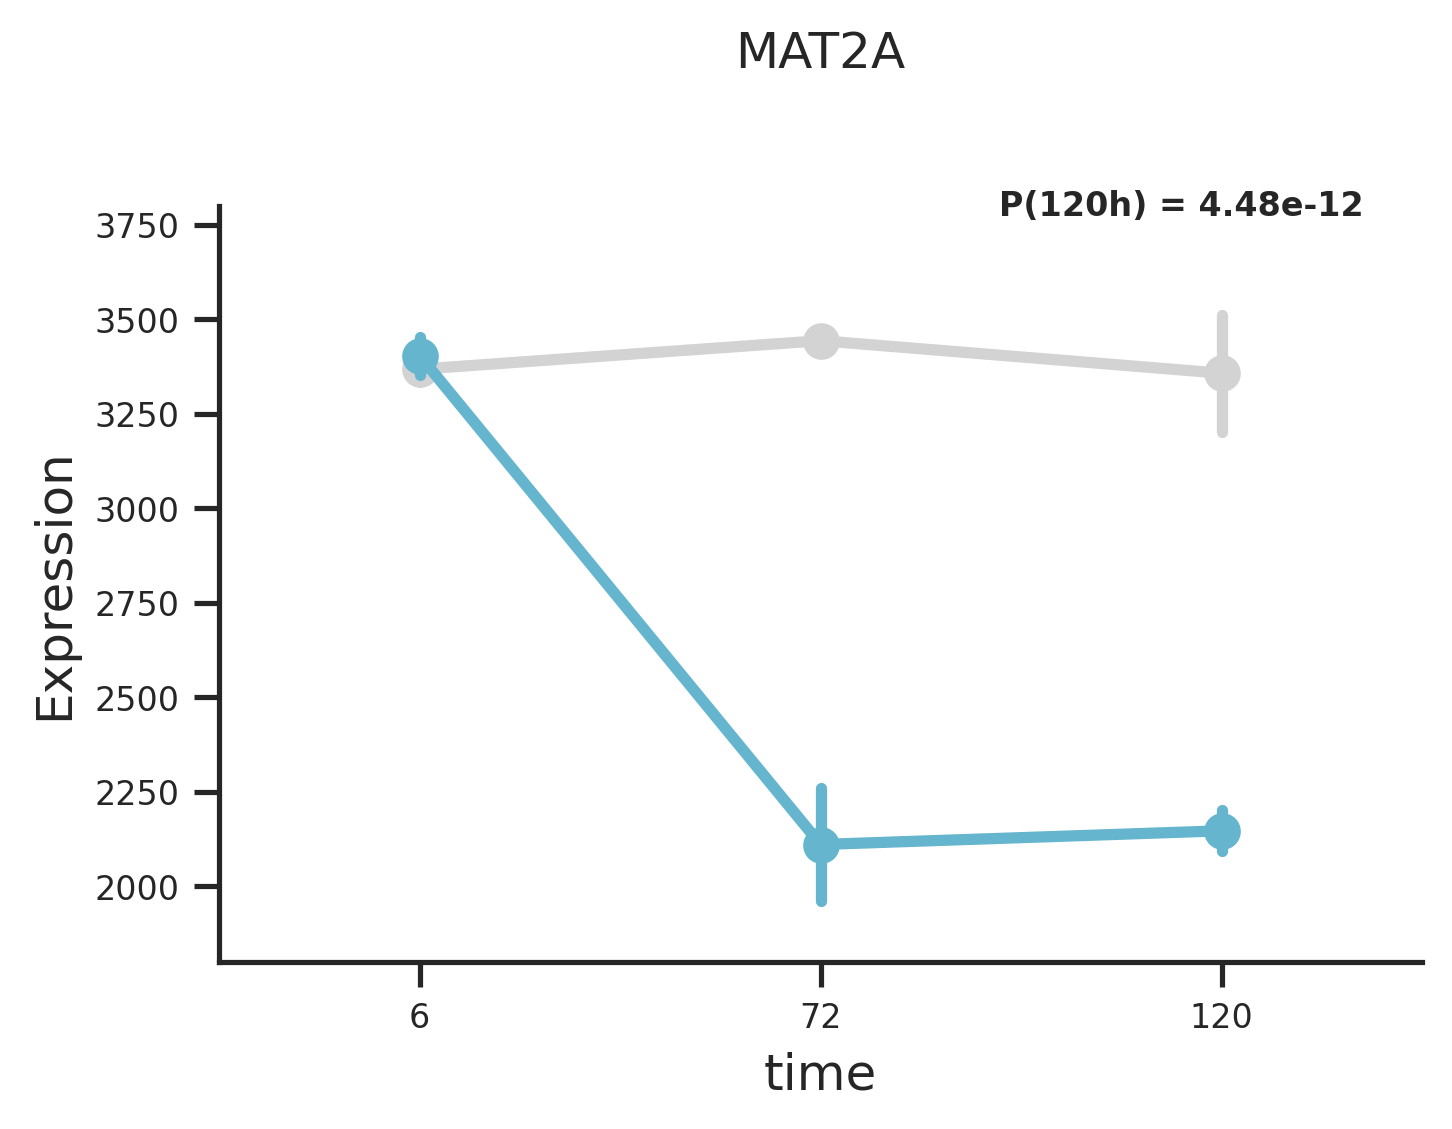

In [133]:
f, ax = plt.subplots(1, 1,figsize=(5,4),dpi=300)

plot_time_rna_seq(
    exp_counts,
    gene = 'MAT2A',
    pvalue=pvalue_str,
    ax=ax,data='Expression',plot='pointplot',ylim=ylim
)

ax.get_legend().remove()
ax.set_ylim(bottom=1800,top=3800)

plt.tight_layout()
# plt.savefig('Target-genes/Stbl.pdf')

### Stability

In [64]:
stbl_counts_norm = pd.read_csv('../RNA-seq/stbl/normalized_stbl_count_table.txt',sep='\t')
stbl_counts = pd.read_csv('../RNA-seq/stbl/REMBRANDTS.txt',sep='\t').set_index('GeneID').loc[stbl_counts_norm.index,]
stbl_counts['name'] = stbl_counts_norm['name']
# stbl_counts.set_index('name',inplace=True)

In [65]:
stbl = pd.read_csv('../RNA-seq/stbl/delta_stbl_table.txt',sep='\t')

In [73]:
stbl.set_index('gene_name').loc[['SQLE','BCL2'],:]
# .filter(regex='hl60')#.filter(regex='h_pvalue')

,hl60_120h_log2FC,hl60_120h_pvalue,hl60_72h_log2FC,hl60_72h_pvalue,hl60_6h_log2FC,hl60_6h_pvalue,kg1_log2FC,kg1_pvalue,molm14_log2FC,molm14_pvalue,ociaml2_log2FC,ociaml2_pvalue,ociaml3_log2FC,ociaml3_pvalue,thp1_log2FC,thp1_pvalue
gene_name,,,,,,,,,,,,,,,,
SQLE,-0.326497,0.033652,-0.106687,0.422241,0.141628,0.210682,0.015310,0.843350,0.024853,0.879954,0.381374,0.030886,-0.092109,0.658859,-0.055117,0.494456
BCL2,-0.364531,0.008860,-0.270596,0.285827,-0.228470,0.027198,-0.048082,0.554119,-0.429219,0.004958,-0.214983,0.090099,0.155364,0.164870,-0.028392,0.748094


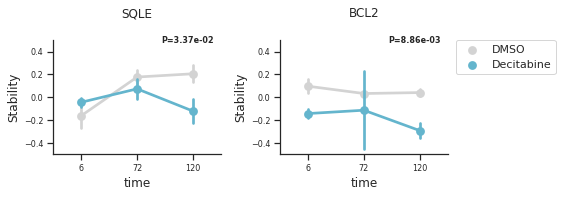

In [103]:
f, axes = plt.subplots(1, 2,figsize=(8,3))

ylim = None

plot_time_rna_seq(
    stbl_counts,gene = 'SQLE',ax=axes[0],data='Stability',plot='pointplot',ylim=ylim, 
    pvalue=stbl.set_index('gene_name').loc['SQLE','hl60_120h_pvalue']
                 )
axes[0].get_legend().remove()
axes[0].set_ylim(bottom=-0.5,top=0.5)

plot_time_rna_seq(
    stbl_counts,gene = 'BCL2',ax=axes[1],data='Stability',plot='pointplot',ylim=ylim, 
    pvalue=stbl.set_index('gene_name').loc['BCL2','hl60_120h_pvalue']
)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[1].set_ylim(bottom=-0.5,top=0.5)

plt.tight_layout()
plt.savefig('Target-genes/Stbl.pdf')

#### up in 6h, GOBP_REGULATION_OF_CHOLESTEROL_BIOSYNTHETIC_PROCESS
- 'NFYA', 'SQLE', 'FDPS', 'SREBF1', 'FDFT1', 'SCAP', 'PRKAA1', 'ERLIN2', 'FASN', 'SREBF2'

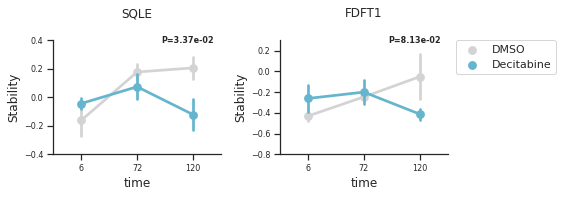

In [69]:
f, axes = plt.subplots(1, 2,figsize=(8,3))

plot_time_rna_seq(
    stbl_counts,gene = 'SQLE',ax=axes[0],data='Stability',plot='pointplot',ylim=ylim, 
    pvalue=stbl.set_index('gene_name').loc['SQLE','hl60_120h_pvalue']
                 )
axes[0].get_legend().remove()
axes[0].set_ylim(bottom=-0.4,top=0.4)

plot_time_rna_seq(
    stbl_counts,gene = 'FDFT1',ax=axes[1],data='Stability',plot='pointplot',ylim=ylim, 
    pvalue=stbl.set_index('gene_name').loc['FDFT1','hl60_120h_pvalue']
)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[1].set_ylim(bottom=-0.8,top=0.3)

plt.tight_layout()
# plt.savefig('Target-genes/Stbl.pdf')

#### up in 120h, GOBP_RESPONSE_TO_STEROL
- 'TGFBR2', 'GRAMD1B', 'TGFBR1', 'LRP8', 'SMAD2', 'CES1'

In [71]:
# # TGFBR2', 'GRAMD1B', 'TGFBR1', 'LRP8', 'SMAD2', 'CES1'
# f, axes = plt.subplots(1, 2,figsize=(8,3))

# plot_time_rna_seq(stbl_counts,gene = 'TGFBR2',ax=axes[0],data='Stability',plot='pointplot',ylim=ylim)
# axes[0].get_legend().remove()
# # axes[0].set_ylim(bottom=-0.4,top=0.4)

# plot_time_rna_seq(stbl_counts,gene = 'TGFBR1',ax=axes[1],data='Stability',plot='pointplot',ylim=ylim)
# axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# # axes[1].set_ylim(bottom=-0.8,top=0.3)

# plt.tight_layout()

> #### FDFT1
> [__Azacitidine in combination with chemotherapy in pediatric AML patients– a phase I study__](https://aml-hub.com/medical-information/azacitidine-in-combination-with-chemotherapy-in-pediatric-aml-patients-a-phase-i-study)
> - _FDFT1 was significantly different between responders and non-responders, P = 0.002_

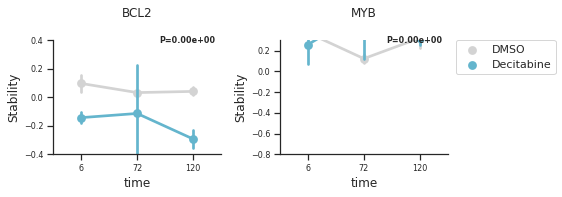

In [72]:
f, axes = plt.subplots(1, 2,figsize=(8,3))

plot_time_rna_seq(stbl_counts,gene = 'BCL2',ax=axes[0],data='Stability',plot='pointplot',ylim=ylim, pvalue=0)
axes[0].get_legend().remove()
axes[0].set_ylim(bottom=-0.4,top=0.4)

plot_time_rna_seq(stbl_counts,gene = 'MYB',ax=axes[1],data='Stability',plot='pointplot',ylim=ylim, pvalue=0)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[1].set_ylim(bottom=-0.8,top=0.3)

plt.tight_layout()
# plt.savefig('Target-genes/Stbl.pdf')

In [ ]:
['MAT2A','MAT1A','MAT2B']

In [107]:
pvalue_120h = 'P(120h) = {:.2e}'.format(
    stbl.set_index('gene_name').loc['MAT2A','hl60_120h_pvalue']
)
pvalue_72h = 'P(72h) = {:.2e}'.format(
    stbl.set_index('gene_name').loc['MAT2A','hl60_72h_pvalue']
)

pvalue_6h = 'P(6h) = {:.2e}'.format(
    stbl.set_index('gene_name').loc['MAT2A','hl60_6h_pvalue']
)

In [109]:
pvalue_str = f'{pvalue_120h}\n{pvalue_72h}\n{pvalue_6h}'

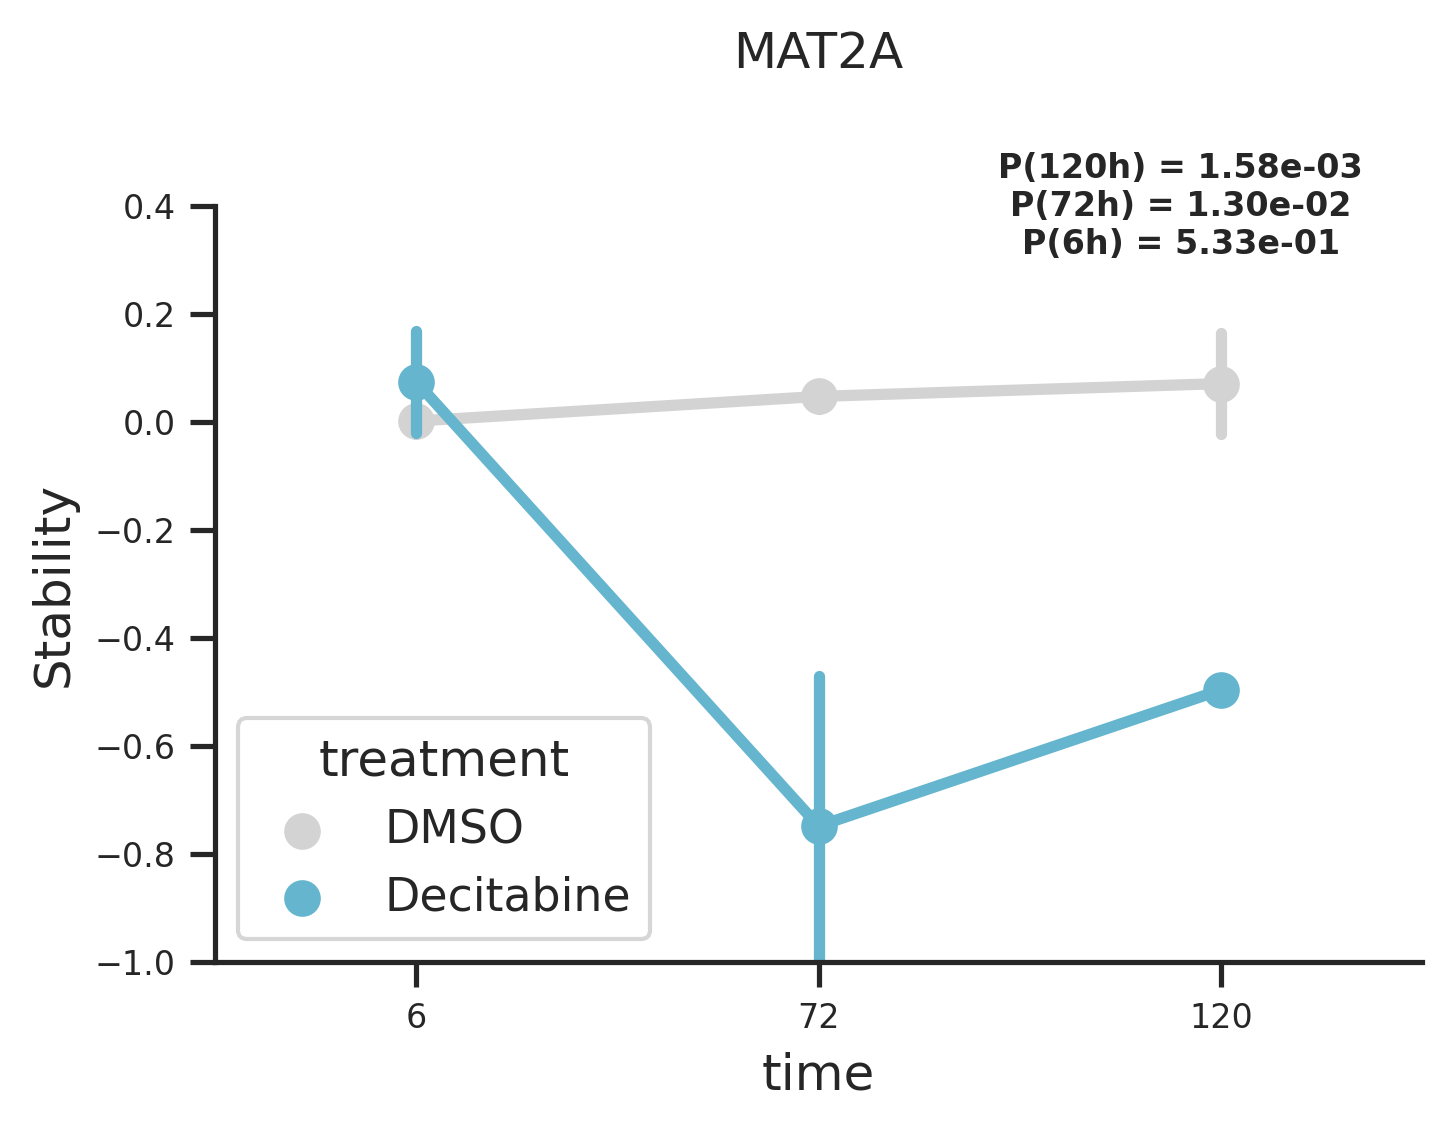

In [120]:
f, ax = plt.subplots(1, 1,figsize=(5,4),dpi=300)

plot_time_rna_seq(
    stbl_counts,
    gene = 'MAT2A',
    pvalue=pvalue_str,
    ax=ax,data='Stability',plot='pointplot',ylim=ylim
)

# ax.get_legend().remove()
ax.set_ylim(bottom=-1,top=0.4)

plt.tight_layout()
# plt.savefig('Target-genes/Stbl.pdf')

# meRIP-seq


> ### $\frac{IP}{Input} (drug)$ vs. $\frac{IP}{Input} (control)$

In [81]:
radar_res = pd.read_csv('../meRIP-seq/hl60_delta_mtyl_table.txt',sep='\t').set_index('ensembl')

In [83]:
radar_res[radar_res.name.isin(['SQLE','INTS5','BCL2','MYBBP1A'])]

,chr,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts,logFC,p_value
ensembl,,,,,,,,,,,,,,
ENSG00000104549.12,chr8,124999289,124999338,SQLE,0,+,124999289,124999338,0,1,49,0,1.113278,0.000235
ENSG00000132382.14,chr17,4539741,4539790,MYBBP1A,0,-,4539741,4539790,0,1,49,0,1.160648,0.002957
ENSG00000171791.13,chr18,63127633,63127682,BCL2,0,-,63127633,63127682,0,1,49,0,-1.619069,0.001442
ENSG00000171791.13,chr18,63318783,63318832,BCL2,0,-,63318783,63318832,0,1,49,0,1.545043,0.003015
ENSG00000185085.2,chr11,62647794,62647843,INTS5,0,-,62647794,62647843,0,1,49,0,1.057699,0.000609
ENSG00000185085.2,chr11,62649635,62649684,INTS5,0,-,62649635,62649684,0,1,49,0,3.295837,0.000383


In [84]:
sqle_id  = 'ENSG00000104549.12'
ints5_id = 'ENSG00000185085.2'
BCL2_id = "ENSG00000171791.13"
MYBBP1A_id = "ENSG00000132382.14"

In [88]:
IN_cnt = pd.read_csv('../meRIP-seq/radar/normalized_Input_counts.txt',sep='\t')
IP_cnt = pd.read_csv('../meRIP-seq/radar/normalized_IP_counts.txt',sep='\t')
ol = set(IP_cnt.index).intersection(set(IN_cnt.index))

sqle_IN_cnt = IN_cnt.loc[[o for o in ol if o.split(',')[0] == sqle_id],:]
sqle_IP_cnt = IP_cnt.loc[[o for o in ol if o.split(',')[0] == sqle_id],:]

ints5_IN_cnt = IN_cnt.loc[[o for o in ol if o.split(',')[0] == ints5_id],:]
ints5_IP_cnt = IP_cnt.loc[[o for o in ol if o.split(',')[0] == ints5_id],:]

In [89]:
BCL2_IN_cnt = IN_cnt.loc[[o for o in ol if o.split(',')[0] == BCL2_id],:]
BCL2_IP_cnt = IP_cnt.loc[[o for o in ol if o.split(',')[0] == BCL2_id],:]

MYBBP1A_IN_cnt = IN_cnt.loc[[o for o in ol if o.split(',')[0] == MYBBP1A_id],:]
MYBBP1A_IP_cnt = IP_cnt.loc[[o for o in ol if o.split(',')[0] == MYBBP1A_id],:]

In [ ]:
sqle_IN_cnt.index.sort_values()

In [ ]:
ints5_IN_cnt.index.sort_values()

In [91]:
def plot_meRIP_count(in_cnt,ip_cnt,title,ax,ylim=None):
    df = pd.DataFrame({
        'Input': in_cnt.mean(),
        'IP': ip_cnt.mean()
    })

    data_title = 'Normalized count'

    df['treatment'] = ["DMSO","DMSO","Decitabine","Decitabine"]
    dd=pd.melt(
        df,
        id_vars='treatment',
        var_name='meRIP'
    ).rename({'value':data_title},axis=1)

    my_pal = {"Decitabine": "c", "DMSO": "lightgray"}

    cleanAxes(ax)
    p = sns.barplot(x='meRIP',y=data_title,data=dd,hue='treatment',palette=my_pal,ax=ax,errwidth=0.4,capsize=.2)

    ax.set_title(title,y=1.1,fontsize=11)
    ax.set_xlabel(None)
    ax.set_ylim(top=ylim)

    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=8)

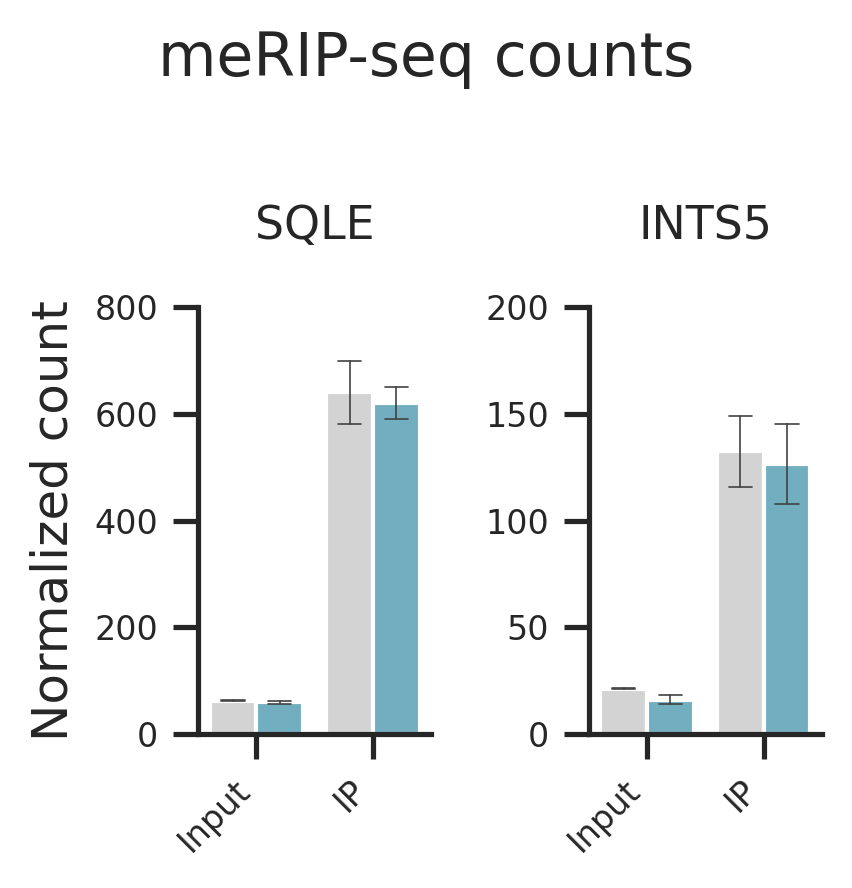

In [92]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(3,3),dpi=300)
ylim=None

plot_meRIP_count(sqle_IN_cnt,sqle_IP_cnt,
                 'SQLE',ax1,ylim=800)
plot_meRIP_count(ints5_IN_cnt,ints5_IP_cnt,
                 'INTS5',ax2,ylim=200)

ax1.get_legend().remove()
ax2.get_legend().remove()


# cleanAxes(ax2,left=False)
ax2.set_ylabel(None)
# ax2.tick_params(axis='y',label1On=False)
# ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 8})

f.suptitle('meRIP-seq counts')
f.tight_layout()
f.savefig('Target-genes/meRIP_counts.pdf')

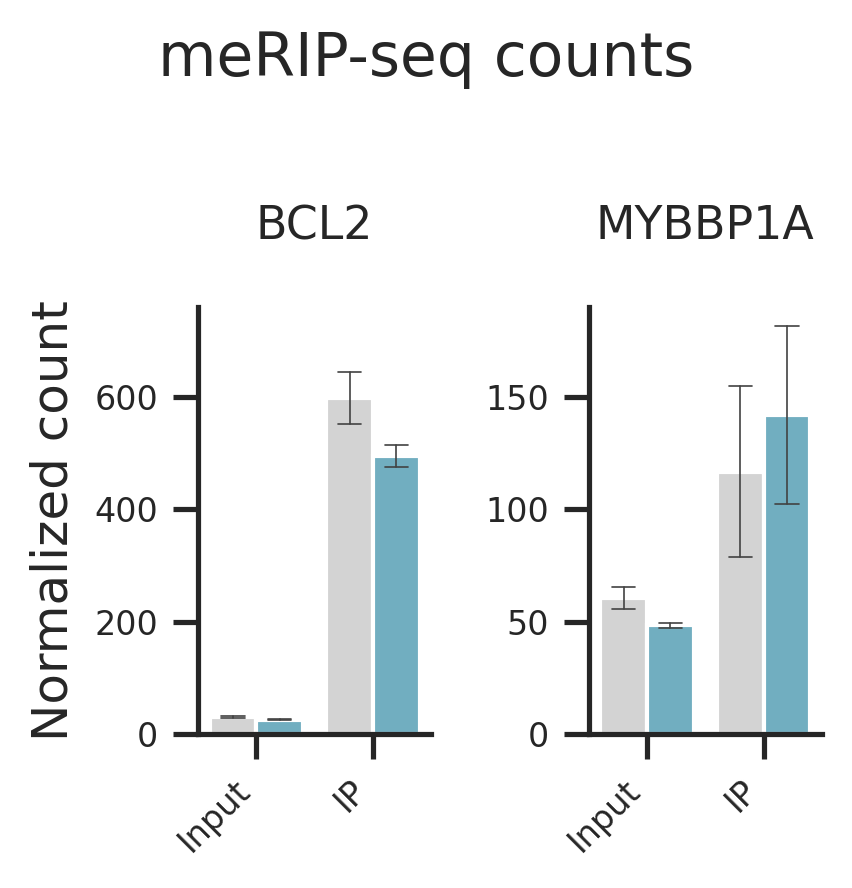

In [100]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(3,3),dpi=300)
ylim=None

plot_meRIP_count(BCL2_IN_cnt,BCL2_IP_cnt,
                 'BCL2',ax1,ylim=760)
plot_meRIP_count(MYBBP1A_IN_cnt,MYBBP1A_IP_cnt,
                 'MYBBP1A',ax2,ylim=190)

ax1.get_legend().remove()
ax2.get_legend().remove()


# cleanAxes(ax2,left=False)
ax2.set_ylabel(None)
# ax2.tick_params(axis='y',label1On=False)
# ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 8})

f.suptitle('meRIP-seq counts')
f.tight_layout()
f.savefig('Target-genes/meRIP_counts_2.pdf')

In [ ]:
# ['MAT2A','MAT1A','MAT2B']
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(5,3),dpi=300)
ylim=None

plot_meRIP_count(sqle_IN_cnt,sqle_IP_cnt,
                 'MAT2A',ax1,ylim=800)
plot_meRIP_count(ints5_IN_cnt,ints5_IP_cnt,
                 'MAT1A',ax2,ylim=200)
plot_meRIP_count(ints5_IN_cnt,ints5_IP_cnt,
                 'MAT2B',ax3,ylim=200)

ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()


# cleanAxes(ax2,left=False)
ax2.set_ylabel(None)
ax3.set_ylabel(None)
# ax2.tick_params(axis='y',label1On=False)
# ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 8})

f.suptitle('meRIP-seq counts')
f.tight_layout()
# f.savefig('Target-genes/meRIP_counts.pdf')

In [101]:
!date

Fri Jul 29 19:35:57 PDT 2022
